# Test segmentation model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
#os.chdir('..')

In [ ]:
# This cell for Google Colab
# Upload the dataset to Google drive to use this notebook in Google Colab
# Uncomment following code for connecting to Google Drive to get access to dataset
# import os,sys,inspect
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/to dataset folder')
# %cd /content/drive/to dataset folder

In [3]:
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)


data_folder = 'test_datasets'
# To use a particular loss functions model, call that model.pth file from the logs folder
model_path = 'logs/unet_isic2018_FocalLoss/unet_isic2018_FocalLoss.pth'

cuda:0


In [4]:
class ISIC2018_dataloader(Dataset):
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        self._input_folder = os.path.join(self._data_folder, 'ISIC2018_Task1-2_Validation_Input')
        self._label_folder = os.path.join(self._data_folder, 'ISIC2018_Task1_Validation_GroundTruth')
        self._images = sorted(glob.glob(self._input_folder + "/*.jpg"))
        self._labels = sorted(glob.glob(self._label_folder + "/*.png"))
        
        self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(self._images, self._labels, 
                                                                            test_size=0.2, shuffle=False, random_state=0)
        
    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('P')
        
        transforms_image = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop((256,256)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop((256,256)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = transforms_mask(mask)
        
        sample = {'image': image, 'mask': mask}
        return sample
    

test_dataset = ISIC2018_dataloader("test_datasets", is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [5]:
# Test model
def test(model):
    model.eval()
    
    with torch.no_grad():
        # test_loss = 0
        jaccard = 0
        dice = 0

        for data in test_dataloader:
            data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            output = model(data.float())  
            # test_loss += criterion(output.float(), target.float()).item()
            
            output = torch.sigmoid(output) # Turn activations into probabilities by feeding through sigmoid
            gt = target.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy()
            pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5

            intersection = pred * gt
            union = pred + gt - intersection
            jaccard += (np.sum(intersection)/np.sum(union))  
            dice += (2. * np.sum(intersection) ) / (np.sum(pred) + np.sum(gt))
    
        # test_loss /= len(test_dataloader)
        jaccard /= len(test_dataloader)
        dice /= len(test_dataloader)

        # losses.append(test_loss)
        # jacs.append(jaccard)
        # dices.append(dice)

        # print('Average Loss: {:.3f}'.format(test_loss))
        print('Jaccard Index : {:.3f}'.format(jaccard * 100))
        print(jaccard)
        print('Dice Coefficient : {:.3f}'.format(dice * 100))
        print(dice)
        print('==========================================')
        print('==========================================')
        # return jaccard

In [6]:
import torchvision

###### UNet model
#########################################################################################
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        # NOTE: 
        # nn.Conv2d(64, 1, kernel_size=1, padding=0) is mathematically same as 
        # nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs
######################################################################################### 


model = build_unet()
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model = model.to(DEVICE)
# model.eval()
test(model)

Jaccard Index : 77.868
0.7786786906421185
Dice Coefficient : 86.075
0.8607530892763936


In [7]:
def visualize(idx, **images):
    """Plot images in one row.""" 
    n = len(images)
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).lower(), fontsize=20)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
        #plt.tight_layout()
    #plt.savefig("../outputs/vis/compare-segs/{}.png".format(idx), facecolor="white", bbox_inches = 'tight')
    plt.show()

In [8]:
len(test_dataloader)
# y[y==1] = 255

20

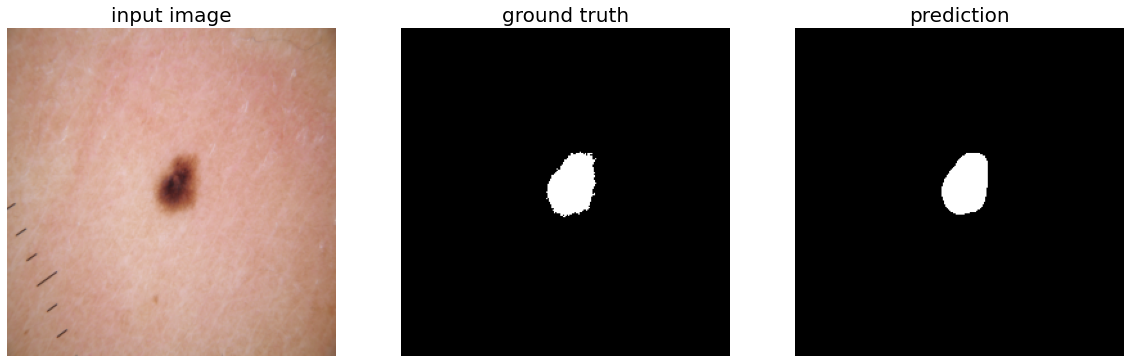

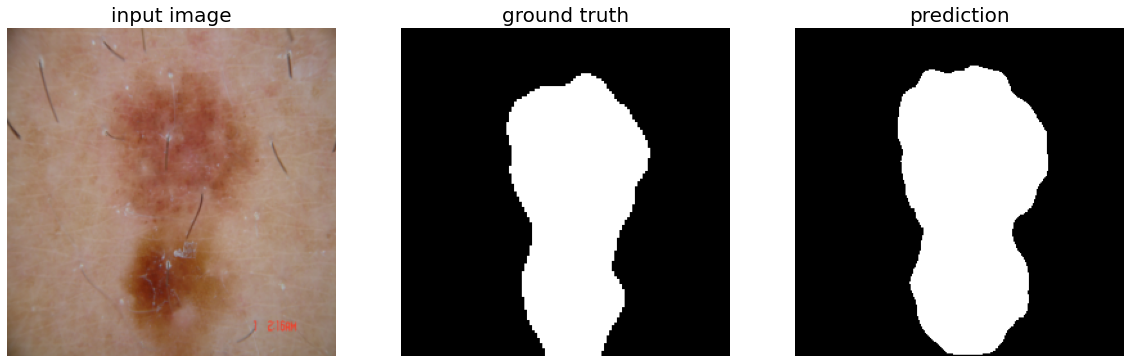

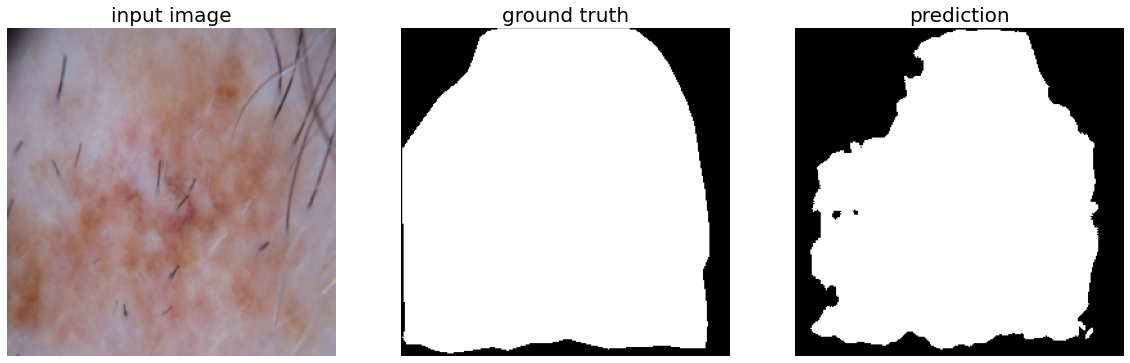

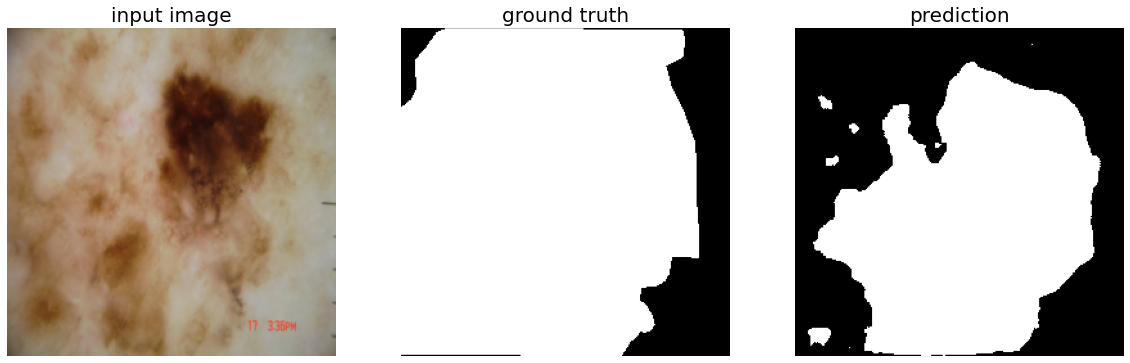

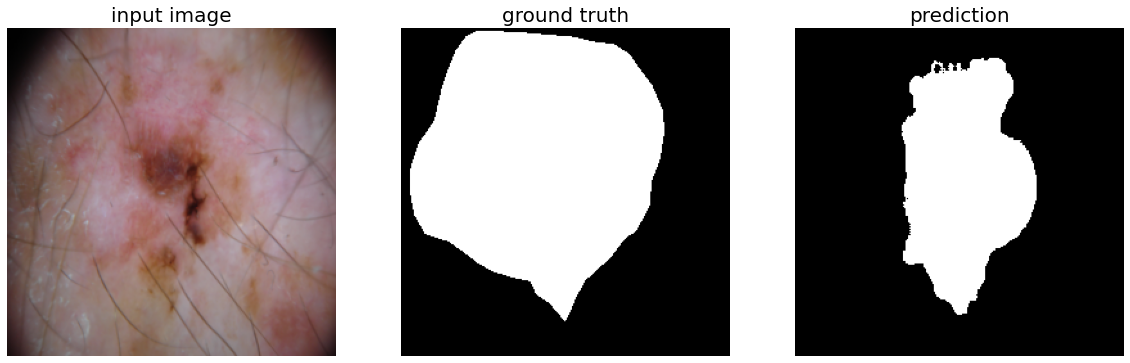

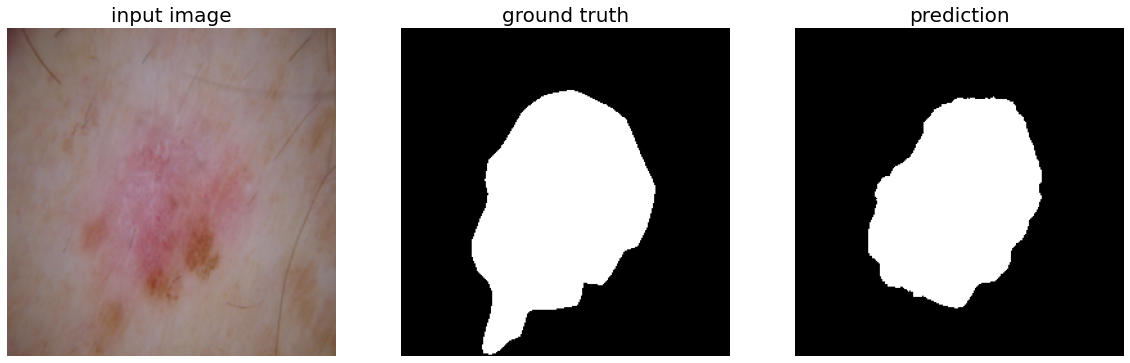

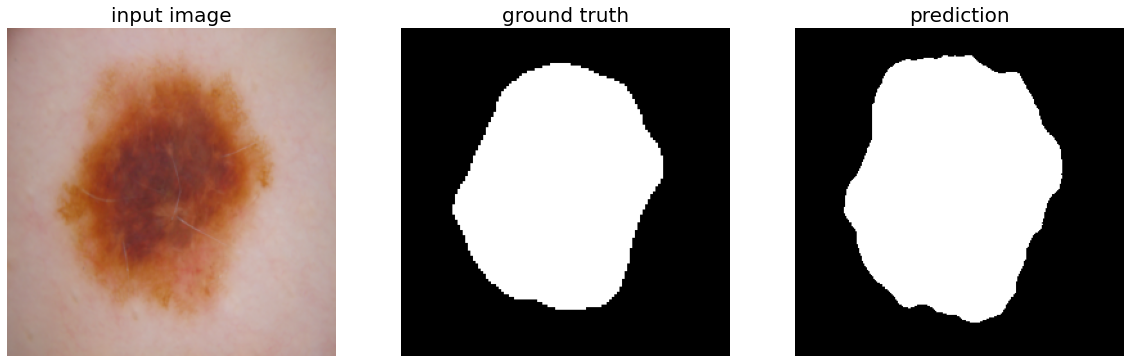

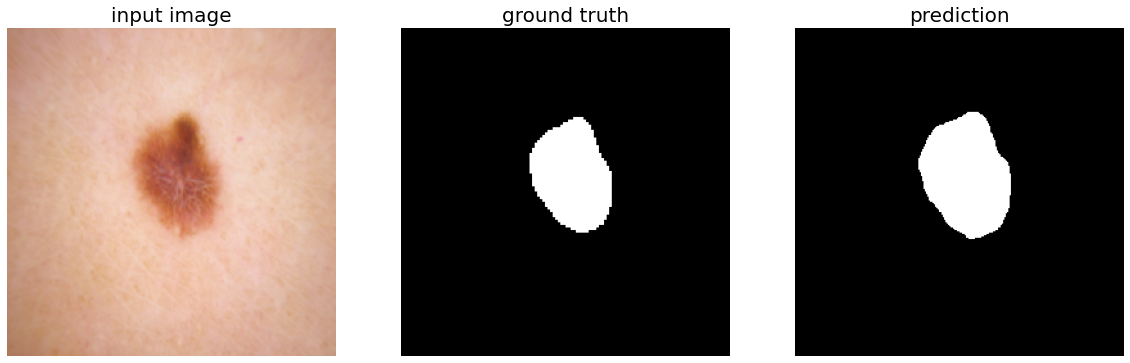

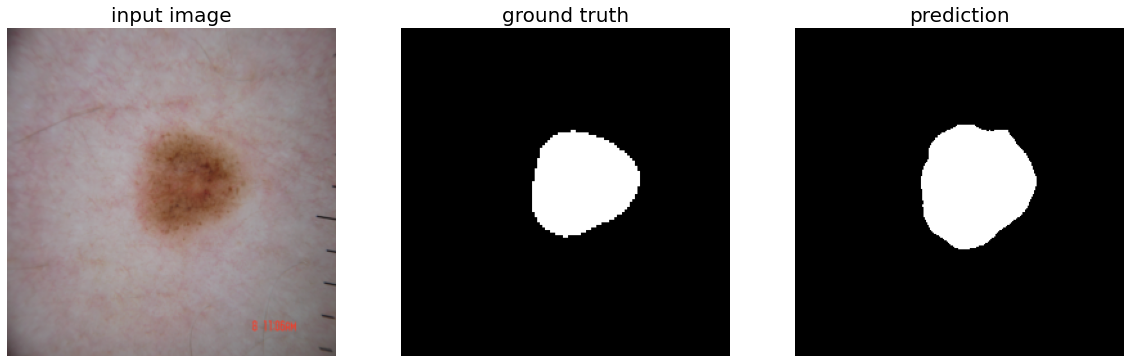

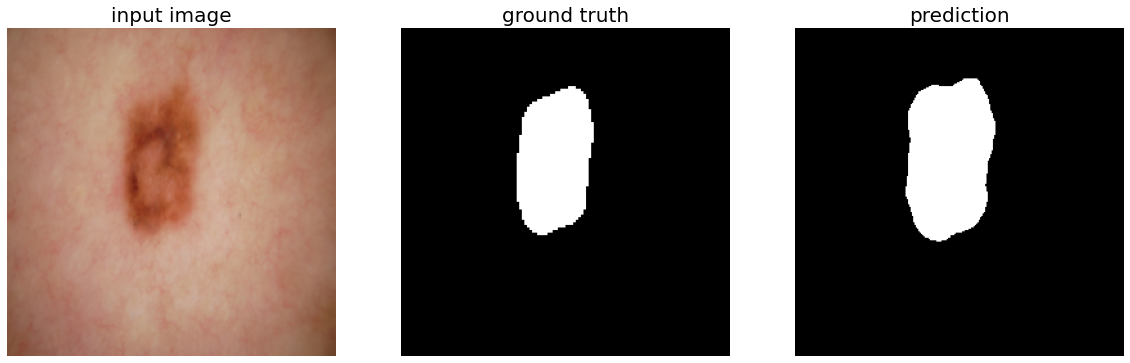

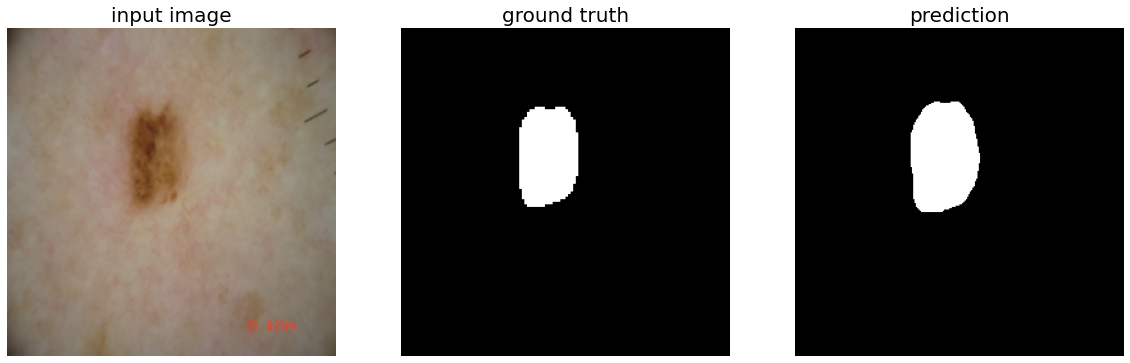

In [9]:
for batch_idx, data in enumerate(test_dataloader):
    img, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
    output = torch.sigmoid(model(img.float()))
    
    img = (img[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    img = (img*255).astype(np.uint8)

    gt = target.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy()
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    visualize(batch_idx, input_image=img, ground_truth=gt, prediction=pred)
    
    if batch_idx == 20: 
        break